In [19]:
! pip install kaggle 

In [20]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [21]:
%run "Unet_implementation.ipynb"

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 256, 256, 64)   │            256 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_37             │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 64)   │              0 │ activation_37[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 128, 128, 128)  │            512 │ conv2d_41[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_39             │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 128)    │              0 │ activation_39[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (None, 64, 64, 256)    │          1,024 │ conv2d_43[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_41             │ (None, 64, 64, 256)    │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 32, 32, 256)    │              0 │ activation_41[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 15,336,513 (58.50 MB)

 Trainable params: 15,330,625 (58.48 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [23]:
import os
os.makedirs('/root/.kaggle', exist_ok=True) 
os.rename('kaggle.json', '/root/.kaggle/kaggle.json') 


In [24]:
! kaggle datasets download nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
brain-tumor-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [25]:
import zipfile

zip_filename = '/content/brain-tumor-segmentation.zip'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [26]:
import os
import numpy as np
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from PIL import Image


In [27]:
base_dir = '/content/'
image_dir = os.path.join(base_dir, 'images')
mask_dir = os.path.join(base_dir, 'masks')


In [28]:
print(len(os.listdir(image_dir)))

3064


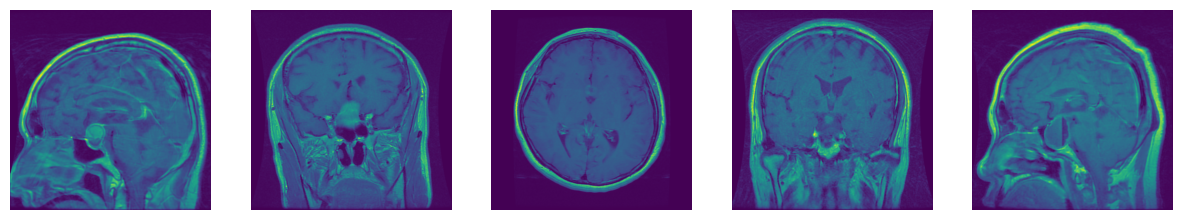

In [29]:
fig = plt.figure(figsize=(15, 10))
j = 0
for i in os.listdir(image_dir)[:5]:
    img = Image.open(os.path.join(image_dir, i))
    plt.subplot(1, 5, j + 1)
    plt.imshow(img)
    plt.axis("off")
    j += 1


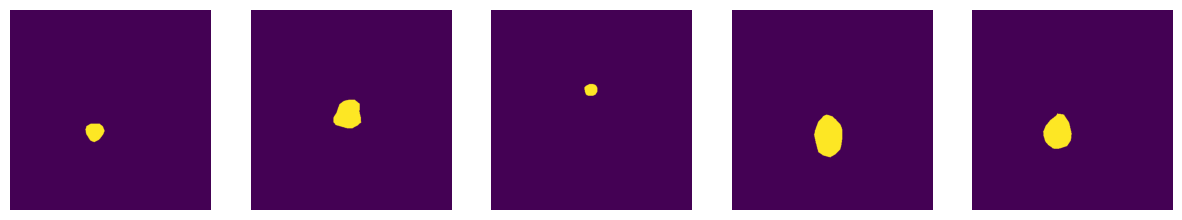

In [30]:
fig = plt.figure(figsize=(15, 10))
j = 0
for i in os.listdir(mask_dir)[:5]:
    img = Image.open(os.path.join(mask_dir, i))
    plt.subplot(1, 5, j + 1)
    plt.imshow(img)
    plt.axis("off")
    j += 1


In [31]:
colors = []
for i in os.listdir(image_dir):
    img = Image.open(os.path.join(image_dir, i))
    colors.append(img.mode)
print(set(colors))

colors = []
for i in os.listdir(mask_dir):
    img = Image.open(os.path.join(mask_dir, i))
    colors.append(img.mode)
print(set(colors))


{'L'}
{'L'}


In [32]:
mri_img = sorted(os.listdir(image_dir))
mask_img = sorted(os.listdir(mask_dir))

# Check if they have the same size
assert len(mri_img) == len(mask_img), "Mismatch in the number of images and masks"

# Train, validation, and test split
tumortrain, tumortest, masktrain, masktest = train_test_split(mri_img, mask_img, test_size=0.3, random_state=42)
tumorval, tumortest, maskval, masktest = train_test_split(tumortest, masktest, random_state=42, test_size=0.5)

# Create directories for train, validation, and test
os.makedirs(os.path.join(base_dir, "Training_data", "MRI"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "Training_data", "Masks"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "Validation_data", "MRI"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "Validation_data", "Masks"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "Testing_data", "MRI"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "Testing_data", "Masks"), exist_ok=True)

# Copy files function
def copy_files(file_list, src_dir, dst_dir):
    for file in file_list:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(dst_dir, file)
        shutil.copy(src_path, dst_path)

# Copy MRI and Mask files
copy_files(tumortrain, image_dir, os.path.join(base_dir, 'Training_data', 'MRI'))
copy_files(masktrain, mask_dir, os.path.join(base_dir, 'Training_data', 'Masks'))

copy_files(tumorval, image_dir, os.path.join(base_dir, 'Validation_data', 'MRI'))
copy_files(maskval, mask_dir, os.path.join(base_dir, 'Validation_data', 'Masks'))

copy_files(tumortest, image_dir, os.path.join(base_dir, 'Testing_data', 'MRI'))
copy_files(masktest, mask_dir, os.path.join(base_dir, 'Testing_data', 'Masks'))


In [60]:
img_size = (128, 128)

def image_mask_generator(image_dir, mask_dir, batch_size, img_size):
    image_list = sorted(os.listdir(image_dir))
    mask_list = sorted(os.listdir(mask_dir))

    while True:
        for i in range(0, len(image_list), batch_size):
            image_batch = []
            mask_batch = []

            for j in range(i, min(i + batch_size, len(image_list))):
                img = Image.open(os.path.join(image_dir, image_list[j]))
                img = img.resize(img_size)
                mask = Image.open(os.path.join(mask_dir, mask_list[j]))
                mask = mask.resize(img_size)

                img = np.array(img) / 255.0  # Normalize the image
                mask = np.array(mask) / 255.0  # Normalize the mask

                image_batch.append(img)
                mask_batch.append(mask)

            yield np.array(image_batch), np.array(mask_batch)


In [61]:
train_generator = image_mask_generator("/content/Training_data/MRI","/content/Training_data/Masks", batch_size=16, img_size=img_size)
val_generator = image_mask_generator("/content/Validation_data/MRI", "/content/Validation_data/Masks", batch_size=16, img_size=img_size)
test_generator = image_mask_generator("/content/Testing_data/MRI", "/content/Testing_data/Masks", batch_size=16, img_size=img_size)


In [62]:
model = bulid_unet((128, 128, 1))  # Make sure the correct input shape is used

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])


In [63]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(os.listdir(os.path.join(base_dir, "Training_data", "MRI"))) // 16,
    validation_steps=len(os.listdir(os.path.join(base_dir, "Validation_data", "MRI"))) // 16
)


Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 202ms/step - accuracy: 0.9054 - loss: 0.3899 - val_accuracy: 0.9799 - val_loss: 0.4501
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - accuracy: 0.9853 - loss: 0.1382 - val_accuracy: 0.9805 - val_loss: 0.2436
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 25s 186ms/step - accuracy: 0.9862 - loss: 0.1078 - val_accuracy: 0.9809 - val_loss: 0.1456
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 193ms/step - accuracy: 0.9871 - loss: 0.0889 - val_accuracy: 0.9811 - val_loss: 0.0966
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 25s 184ms/step - accuracy: 0.9880 - loss: 0.0750 - val_accuracy: 0.9831 - val_loss: 0.0806
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.9888 - loss: 0.0642 - val_accuracy: 0.9839 - val_loss: 0.0708
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 192ms/step - accuracy: 0.9897 - loss: 0.0551 - val_accuracy: 0.9848 - val_loss: 0.0629
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 25s 186ms/step - accuracy: 0.9905 - loss: 0

In [37]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(os.listdir(os.path.join(base_dir, "Testing_data", "MRI"))) // 32)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.9877 - loss: 0.0922
Test Loss: 0.09792426973581314
Test Accuracy: 0.9848830103874207


In [38]:
model.save("image_segmentation.h5")

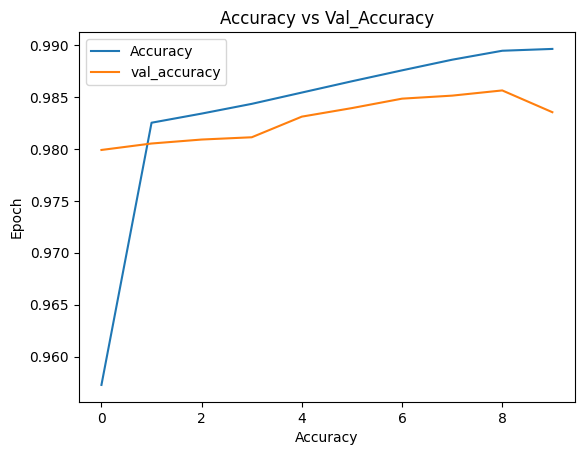

In [74]:
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.title("Accuracy vs Val_Accuracy")
plt.savefig("accuracy vs val_accuracy.png")

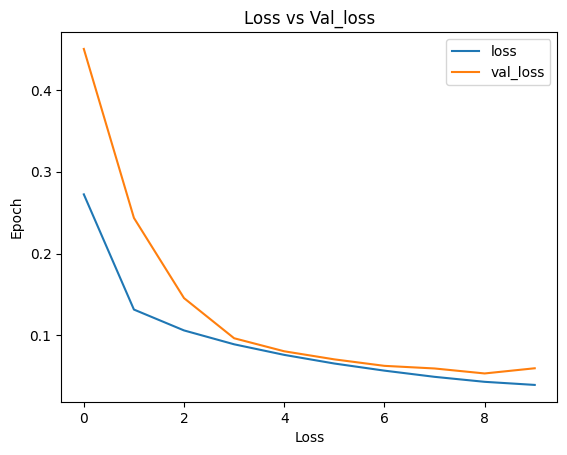

In [75]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend()
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.title("Loss vs Val_loss")
plt.savefig("Loss vs Val_loss.png")

In [66]:
import numpy as np

image_path = "/content/images/76.png"
input_image = Image.open(image_path)

input_size = (128, 128)
input_image = np.array(input_image.resize(input_size))

input_image = input_image / 255.0 

input_image.shape

(128, 128)

In [67]:
predicted_mask = model.predict(input_image.reshape(1,128,128,1))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


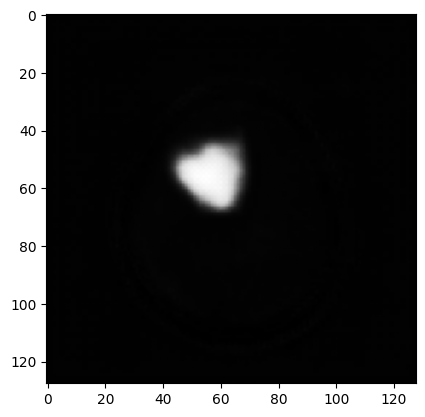

In [76]:
plt.imshow(predicted_mask,cmap='gray')
plt.savefig("predicted_mask.png")

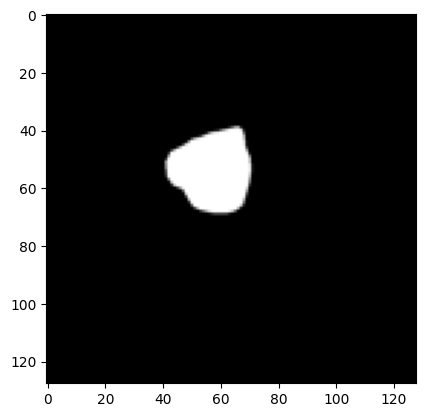

In [77]:
img=Image.open("/content/masks/76.png")
img=np.array(img.resize((128,128)))
img=(img/255.0)
plt.imshow(img,cmap='gray')
plt.savefig("actual_mask.png")